### Background:  Pivot Bio runs an extensive field demonstration program to introduce farmers to our products, covering thousands of acres across the United States. Ideally, we would have an agronomist visit every farmer to address issues, but as we include more and more farmers it becomes harder and harder to visit. We have established a UAV imagery process that allows for monitoring and quality control of smaller trials, but we need a UAV based process to monitor our on-farm and commercial trials. Ideally, the system would inform Agronomists when an issue is detected, so they can contact the grower.   

### Goal: Development of a model using satellite/UAV remote sensing datasets from free repositories to detect product failure with > 60% accuracy by the V6 crop growth stage 

# Collect data from S3

In [1]:
import ftl.dw_call as dw
import boto3
from copy import deepcopy
from pathlib import Path
import os
import shutil
import glob

import pandas as pd
from pandas.errors import ParserError
import numpy as np
from datetime import datetime
from fiona.collection import DriverError
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import geopandas as gpd
from osgeo import gdal
from shapely.ops import unary_union
from shapely.geometry import Polygon
from io import BytesIO
import rasterio
import rasterio as rio
import rasterio.plot
from rasterio.transform import Affine
from rasterstats import zonal_stats
import pyproj

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score

In [3]:
### We will work on protocol '22-ZEAMX-US501' first
keys = ['22-ZEAMX-US501']

### Download & Calculation: access sataellite data (plots and image) from S3; calculate 

In [4]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('pivot-uav-collab')

non_raw = []
for kw in keys:
    print(f"Accessing Keyword: {kw}")
    objects = bucket.objects.filter(
        Prefix=f'planet/{kw}',
        MaxKeys=40000
    )

    non_raw.extend([x for x in objects if '_RAW' not in x.key.upper()])
rasters = {
    x.key: x.bucket_name for x in non_raw 
    if any(s in x.key.upper() for s in ['_MULTISPECTRAL.',])
}

plots = {
    x.key: x.bucket_name for x in non_raw 
    if 'GPKG' in x.key.upper()
}

Accessing Keyword: 22-ZEAMX-US501


In [5]:
print(len(plots))
plots

30


{'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA02-5GAUL/22-ZEAMX-US501-IA02-5GAUL_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA03-5NICHO/22-ZEAMX-US501-IA03-5NICHO_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA04-5HANSE/22-ZEAMX-US501-IA04-5HANSE_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA05-5SHOOK/22-ZEAMX-US501-IA05-5SHOOK_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA06-5STORB/22-ZEAMX-US501-IA06-5STORB_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IL01-5DENTO/22-ZEAMX-US501-IL01-5DENTO_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IL02-5WADE/22-ZEAMX-US501-IL02-5WADE_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IL03-5JONES/22-ZEAMX-US501-IL03-5JONES_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IL04-5LAUX/22-ZEAMX-US501-IL04-5LAUX_plots.gpkg': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IN01-5GOHN/22-ZEAMX-US

In [6]:
print(len(rasters))
rasters

1776


{'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220602_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220603_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220609_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220613_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220614_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220616_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US501-IA01-5FELDM_20220617_ANALYTIC5B_MULTISPECTRAL.tif': 'pivot-uav-collab',
 'planet/22-ZEAM

In [9]:
def read_s3_contents(bucket_name, key):
    response = s3.Object(bucket_name, key).get()
    return response['Body'].read()

def calc_nd(band1, band2):
    return((band1 - band2) / (band1 + band2))

def multipolygon_to_polygon(geometry):
    if geometry.geom_type.lower() == 'multipolygon':
        return geometry.geoms[0]
    else:
        return geometry

In [8]:
%%time
full = []
failed = {}
for image, bucket in rasters.items():
    # get image metadata
    trial, file = image.split(r'/')[-2:]
    date = file.split(r'_')[1]
    
    # search for matching plots on trial name
    try:
        plot = [x for x in plots.keys() if trial in x][0]
    except IndexError:
        failed.update({image:'no plot (indexerror)'})
        continue
    
    # read in plots and buffer 1m inwards
    try:
        gpkg = gpd.read_file(BytesIO(read_s3_contents(bucket, plot)))
        gpkg = gpkg.dropna(axis='columns', how='all')
    except DriverError:
        failed.update({plot:'plot issue (drivererror)'})
        continue
    if not set([
        'trial_id', 'plot', 'row', 'col', 'treatment', 'geometry'
    ]).issubset(set(gpkg.columns)):
        failed.update({plot:'plot metadata issue (missing column)'})
        continue
    if gpkg.crs.axis_info[0].unit_name != 'metre':
        gpkg = gpkg.to_crs('epsg:5070')
    gpkg['geometry'] = gpkg['geometry'].apply(multipolygon_to_polygon)
    gpkg['geometry'] = gpkg.buffer(-1)
    
    # read in image
    with rio.open(BytesIO(read_s3_contents(bucket, image))) as src:
        data = src.read()
        profile = src.profile
    
    # set plot crs to image crs
    if not profile['crs'] == gpkg.crs:
        gpkg = gpkg.to_crs(profile['crs'])

    # band math
    vis = {}
    vis['ndvi'] = calc_nd(data[4], data[2])
    vis['ndre'] = calc_nd(data[4], data[3])
    try:
        ndvi = pd.DataFrame(zonal_stats(
            gpkg,
            vis['ndvi'],
            affine=profile['transform'],
            stats=['mean', 'std']
        ))
    except AttributeError:
        failed.update({image:'zonal stats issue (attributeerror)'})
        continue
    ndvi = ndvi.rename(columns={x: f'ndvi_{x}' for x in ndvi.columns})
    ndre = pd.DataFrame(zonal_stats(
        gpkg,
        vis['ndre'],
        affine=profile['transform'],
        stats=['mean', 'std']
    ))
    ndre = ndre.rename(columns={x:f'ndre_{x}' for x in ndre.columns})
    
    gpkg['flight_date'] = date
    gpkg['filename'] = plot
    gpkg['flightname'] = file
    try:
        gpkg['flight_date'] = pd.to_datetime(gpkg['flight_date'])
    except:
        pass
    out = pd.concat([gpkg, ndvi, ndre], axis=1)
    full.append(out)


Wall time: 24min 28s


In [10]:
failed

{}

In [16]:
full

[    plot        Protocol                    trial_id  col  row        PB_Trt  \
 0    206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1           NTC   
 1    101  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    1    1           NTC   
 2    203  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    9    1     2022-PVX2   
 3    104  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    4    1     2022-PVX2   
 4    106  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    6    1  2022-PBX5WAY   
 5    103  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    3    1           NTC   
 6    102  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    2    1      2022-PVX   
 7    205  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   11    1  2022-PBX5WAY   
 8    201  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    7    1      2022-PVX   
 9    105  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    5    1  2022-PBX3WAY   
 10   202  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    8    1           NTC   
 11   204  22-ZEAMX-US501  2

In [93]:
df = pd.concat(full)
df['protocol__name'] = df['trial_id'].str.rsplit('-', 2).str[0]
# there's an issue with a file flight date
# df.loc[df['flight_date']=='08172022', 'flight_date'] = '20220817'
df['flight_date'] = pd.to_datetime(df['flight_date'])
df.groupby(['protocol__name', 'trial_id']).agg({'flight_date':'nunique'})

flight_date
protocol__name trial_id                               
22-ZEAMX-US501 22-ZEAMX-US501-IA01-5FELDM           79
               22-ZEAMX-US501-IA02-5GAUL            62
               22-ZEAMX-US501-IA03-5NICHO           65
               22-ZEAMX-US501-IA04-5HANSE           73
               22-ZEAMX-US501-IA05-5SHOOK           72
               22-ZEAMX-US501-IA06-5STORB           55
               22-ZEAMX-US501-IL01-5DENTO           58
               22-ZEAMX-US501-IL02-5WADE            49
               22-ZEAMX-US501-IL03-5JONES           56
               22-ZEAMX-US501-IL04-5LAUX            66
               22-ZEAMX-US501-IN01-5GOHN            59
               22-ZEAMX-US501-IN02-5STAHL           70
               22-ZEAMX-US501-IN03-5SMITH           59
               22-ZEAMX-US501-KS01-5BIGHA           60
               22-ZEAMX-US501-MI01-5GENTZ           55
               22-ZEAMX-US501-MI02-5MORSE           54
               22-ZEAMX-US501-MN01-5DOMNI           43
               22-ZEAMX-US501-MN03-5RUDNI           51
               22-ZEAMX-US501-MO01-5DYE             70
               22-ZEAMX-US501-MS01-5ARRIN           28
               22-ZEAMX-US501-MS02-5HURRI           42
               22-ZEAMX-US501-MS03-5HURRI           48
               22-ZEAMX-US501-NC01-5WILLI           48
               22-ZEAMX-US501-ND01-5PETER           63
               22-ZEAMX-US501-NE02-5KOEHN           61
               22-ZEAMX-US501-OH01-5BOND            36
               22-ZEAMX-US501-OH02-5RUPP            54
               22-ZEAMX-US501-OK01-5ISAAC           78
               22-ZEAMX-US501-SD02-5ALVER           74
               22-ZEAMX-US501-TX01-5POHNE           88

In [13]:
df.groupby(['protocol__name']).agg({'trial_id':'nunique'})

trial_id
protocol__name          
22-ZEAMX-US501        30

In [343]:
# df.to_csv('Planet501_info.csv',index=False)

In [18]:
df.head()

plot        Protocol                    trial_id  col  row        PB_Trt  \
0   206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1           NTC   
1   101  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    1    1           NTC   
2   203  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    9    1     2022-PVX2   
3   104  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    4    1     2022-PVX2   
4   106  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    6    1  2022-PBX5WAY   

       Fert_trt  treatment                                           geometry  \
0        N:100%          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...   
1        N:100%          1  POLYGON ((-93.62041 41.86560, -93.62042 41.865...   
2  N:100%-50 LB          4  POLYGON ((-93.62043 41.86429, -93.62044 41.864...   
3  N:100%-50 LB          4  POLYGON ((-93.62042 41.86511, -93.62042 41.865...   
4  N:100%-50 LB          6  POLYGON ((-93.62043 41.86478, -93.62043 41.864...   

  flight_date                                           filename  \
0  2022-06-01  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
1  2022-06-01  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
2  2022-06-01  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
3  2022-06-01  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
4  2022-06-01  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   

                                          flightname  ndvi_mean  ndvi_std  \
0  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.329640  0.126840   
1  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.260044  0.129612   
2  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.303751  0.125496   
3  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.297243  0.133003   
4  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.318133  0.155143   

   ndre_mean  ndre_std  OBJECTID  Shape_Leng  Shape_Le_1  Shape_Length  \
0   0.154118  0.131604       NaN         NaN         NaN           NaN   
1   0.129890  0.110995       NaN         NaN         NaN           NaN   
2   0.161806  0.090118       NaN         NaN         NaN           NaN   
3   0.127028  0.155873       NaN         NaN         NaN           NaN   
4   0.152862  0.140535       NaN         NaN         NaN           NaN   

   Shape_Area  SHAPE_LENG PROTOCOL PB_TRT FERT_TRT  SHAPE_LE_1  Name Fert_Trt  \
0         NaN         NaN      NaN    NaN      NaN         NaN   NaN      NaN   
1         NaN         NaN      NaN    NaN      NaN         NaN   NaN      NaN   
2         NaN         NaN      NaN    NaN      NaN         NaN   NaN      NaN   
3         NaN         NaN      NaN    NaN      NaN         NaN   NaN      NaN   
4         NaN         NaN      NaN    NaN      NaN         NaN   NaN      NaN   

   protocol__name  
0  22-ZEAMX-US501  
1  22-ZEAMX-US501  
2  22-ZEAMX-US501  
3  22-ZEAMX-US501  
4  22-ZEAMX-US501

In [96]:
df_new=df.iloc[:,0:16]

In [31]:
df_new.head(2)

plot        Protocol                    trial_id  col  row PB_Trt Fert_trt  \
0   206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   N:100%   
1   101  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM    1    1    NTC   N:100%   

   treatment                                           geometry flight_date  \
0          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...  2022-06-01   
1          1  POLYGON ((-93.62041 41.86560, -93.62042 41.865...  2022-06-01   

                                            filename  \
0  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
1  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   

                                          flightname  ndvi_mean  ndvi_std  \
0  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.329640  0.126840   
1  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.260044  0.129612   

   ndre_mean  ndre_std  
0   0.154118  0.131604  
1   0.129890  0.110995

###  Match the growth stage

In [19]:
### read stage data
data = pd.read_csv('22-ZEAMX-US501 metadata and growthstage date estimates.csv')
data.head(2)

trial_id  year        protocol experiment_name  \
0  22-ZEAMX-US501-IA01-5FELDM  2022  22-ZEAMX-US501       FTR001148   
1   22-ZEAMX-US501-IA02-5GAUL  2022  22-ZEAMX-US501       FTR001149   

                   trial_id.1 planting_date harvest_date  \
0  22-ZEAMX-US501-IA01-5FELDM       5/30/22      11/2/22   
1   22-ZEAMX-US501-IA02-5GAUL       5/24/22     10/31/22   

                 gps_center qc_score  qc_notes  estimated_harvest_date  \
0  41.86343116,-93.62011716   Yellow       NaN                   False   
1  42.64824296,-91.39564924   Yellow       NaN                   False   

       V0       VE       V1       V2       V3       V4       V5       V6  \
0  6/4/22  6/11/22  6/14/22  6/17/22  6/20/22  6/22/22  6/25/22  6/29/22   
1  6/1/22  6/11/22  6/14/22  6/17/22  6/21/22  6/24/22  6/27/22   7/1/22   

       V7      V8       V9      V10      V11      V12       VT       R1  \
0  7/1/22  7/5/22   7/7/22  7/10/22  7/12/22  7/23/22  7/29/22  8/20/22   
1  7/4/22  7/7/22  7/10/22  7/13/22  7/17/22  7/28/22   8/4/22  8/30/22   

        R2       R3       R4       R5        R6      R6+  
0  8/28/22   9/5/22  9/16/22  10/9/22  10/12/22  11/3/22  
1   9/8/22  9/18/22  10/4/22  11/1/22       NaN      NaN

In [20]:
filtered_data= data.iloc[:,[0]+[8]+list(range(11,33))]

### transfer the string to datetime
stage=filtered_data.iloc[:,2:24].applymap(lambda x: datetime.strptime(x, "%m/%d/%y").date() if not pd.isna(x) else x)
stage['trial_id']=filtered_data['trial_id']
stage['qc_score']=filtered_data['qc_score']

In [49]:
trials=df_new['trial_id'].tolist()
dates=df_new['flight_date'].tolist()
growth_stages=[]

for i in range(len(trials)):
    ### get trail_id and image date
    trial_id = str(trials[i])
    date_string = str(dates[i]).split()[0]
    date_format = "%Y-%m-%d"
    
    ### match the exact trail
    select=stage[stage['trial_id'] == trial_id]
    
    ### match the date and save
    growth_stage=select.iloc[0,0:-2].sub(datetime.strptime(date_string, date_format).date()).abs().idxmin()
    growth_stages.append(growth_stage)

In [50]:
df_new['stage']=growth_stages

In [40]:
df_new['stage'].unique()

array(['V0', 'VE', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V10', 'V11',
       'V12', 'VT', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R6+', 'V9', 'V8'],
      dtype=object)

### Get the yield data

In [78]:
all_yield = pd.read_csv('biomass_measurements__yield_bu_acre.csv')
all_yield.head(3)

protocol__name        experiment__trial_id  plot__lookup_key  \
0  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM             101.0   
1  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM             102.0   
2  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM             103.0   

                 experiment__gps_center       value  
0  41.86343116382189,-93.62011715769768  259.772300  
1  41.86343116382189,-93.62011715769768  254.944092  
2  41.86343116382189,-93.62011715769768  245.545464

In [79]:
### extract the yield column and GPS center of the plot
all_yield.columns=['Protocol','trial_id','plot','GPS_center','yield']
all_yield.head(3)

Protocol                    trial_id   plot  \
0  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM  101.0   
1  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM  102.0   
2  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM  103.0   

                             GPS_center       yield  
0  41.86343116382189,-93.62011715769768  259.772300  
1  41.86343116382189,-93.62011715769768  254.944092  
2  41.86343116382189,-93.62011715769768  245.545464

In [80]:
df_merge3=pd.merge(df_new,all_yield,on=['trial_id','plot'])
# df_merge3.to_csv('merged501_data.csv',index=False)
df_merge3

plot      Protocol_x                    trial_id  col  row PB_Trt  \
0       206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   
1       206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   
2       206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   
3       206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   
4       206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   
...     ...             ...                         ...  ...  ...    ...   
20521   101  22-ZEAMX-US501  22-ZEAMX-US501-TX01-5POHNE    1    1    NTC   
20522   101  22-ZEAMX-US501  22-ZEAMX-US501-TX01-5POHNE    1    1    NTC   
20523   101  22-ZEAMX-US501  22-ZEAMX-US501-TX01-5POHNE    1    1    NTC   
20524   101  22-ZEAMX-US501  22-ZEAMX-US501-TX01-5POHNE    1    1    NTC   
20525   101  22-ZEAMX-US501  22-ZEAMX-US501-TX01-5POHNE    1    1    NTC   

      Fert_trt  treatment                                           geometry  \
0       N:100%          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...   
1       N:100%          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...   
2       N:100%          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...   
3       N:100%          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...   
4       N:100%          1  POLYGON ((-93.62044 41.86380, -93.62044 41.863...   
...        ...        ...                                                ...   
20521   N:100%          1  POLYGON ((-101.17649 35.39885, -101.16931 35.3...   
20522   N:100%          1  POLYGON ((-101.17649 35.39885, -101.16931 35.3...   
20523   N:100%          1  POLYGON ((-101.17649 35.39885, -101.16931 35.3...   
20524   N:100%          1  POLYGON ((-101.17649 35.39885, -101.16931 35.3...   
20525   N:100%          1  POLYGON ((-101.17649 35.39885, -101.16931 35.3...   

      flight_date                                           filename  \
0      2022-06-01  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
1      2022-06-02  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
2      2022-06-03  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
3      2022-06-09  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
4      2022-06-13  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
...           ...                                                ...   
20521  2022-10-25  planet/22-ZEAMX-US501-TX01-5POHNE/22-ZEAMX-US5...   
20522  2022-10-26  planet/22-ZEAMX-US501-TX01-5POHNE/22-ZEAMX-US5...   
20523  2022-10-30  planet/22-ZEAMX-US501-TX01-5POHNE/22-ZEAMX-US5...   
20524  2022-10-31  planet/22-ZEAMX-US501-TX01-5POHNE/22-ZEAMX-US5...   
20525  2022-11-02  planet/22-ZEAMX-US501-TX01-5POHNE/22-ZEAMX-US5...   

                                              flightname  ndvi_mean  ndvi_std  \
0      22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.329640  0.126840   
1      22-ZEAMX-US501-IA01-5FELDM_20220602_ANALYTIC5B...   0.390106  0.088408   
2      22-ZEAMX-US501-IA01-5FELDM_20220603_ANALYTIC5B...   0.390642  0.053602   
3      22-ZEAMX-US501-IA01-5FELDM_20220609_ANALYTIC5B...   0.386687  0.039191   
4      22-ZEAMX-US501-IA01-5FELDM_20220613_ANALYTIC5B...   0.501900  0.102390   
...                                                  ...        ...       ...   
20521  22-ZEAMX-US501-TX01-5POHNE_20221025_ANALYTIC5B...   0.294094  0.256510   
20522  22-ZEAMX-US501-TX01-5POHNE_20221026_ANALYTIC5B...   0.304760  0.211524   
20523  22-ZEAMX-US501-TX01-5POHNE_20221030_ANALYTIC5B...   0.319794  0.190175   
20524  22-ZEAMX-US501-TX01-5POHNE_20221031_ANALYTIC5B...   0.375471  0.180464   
20525  22-ZEAMX-US501-TX01-5POHNE_20221102_ANALYTIC5B...   0.269678  0.138529   

       ndre_mean  ndre_std stage      Protocol_y  \
0       0.154118  0.131604    V0  22-ZEAMX-US501   
1       0.373614  0.090695    V0  22-ZEAMX-US501   
2       0.347209  0.070734    V0  22-ZEAMX-US501   
3       0.311988  0.042532    VE  22-ZEAMX-US501   
4       0.235274  0.112921    V1  2

In [65]:
df_merge3[['treatment', 'Fert_trt', 'PB_Trt']].value_counts().sort_index()

treatment  Fert_trt      PB_Trt      
1          N:100%        NTC             3110
2          N:100%-50 LB  2022-PVX        3110
3          N:100%-50 LB  NTC             3110
4          N:100%-50 LB  2022-PVX2       3110
5          N:100%-50 LB  2022-PBX3WAY    3110
6          N:100%-50 LB  2022-PBX5WAY    3110
dtype: int64

In [68]:
### no image
### 22-ZEAMX-US501-TN01-5VEREL

### no field data
### 22-ZEAMX-US501-NC01-5WILLI

### Drop NaN values

In [3]:
# df_load=pd.read_csv('merged501_data.csv')
# df_merge3=df_load.copy()

In [6]:
df_merge3.columns

Index(['plot', 'Protocol_x', 'trial_id', 'col', 'row', 'PB_Trt', 'Fert_trt',
       'treatment', 'geometry', 'flight_date', 'filename', 'flightname',
       'ndvi_mean', 'ndvi_std', 'ndre_mean', 'ndre_std', 'stage', 'Protocol_y',
       'GPS_center', 'yield'],
      dtype='object')

In [7]:
df_merge3.head(2) 

plot      Protocol_x                    trial_id  col  row PB_Trt Fert_trt  \
0   206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   N:100%   
1   206  22-ZEAMX-US501  22-ZEAMX-US501-IA01-5FELDM   12    1    NTC   N:100%   

   treatment                                           geometry flight_date  \
0          1  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-01   
1          1  POLYGON ((-93.62044187504478 41.86379593747736...  2022-06-02   

                                            filename  \
0  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   
1  planet/22-ZEAMX-US501-IA01-5FELDM/22-ZEAMX-US5...   

                                          flightname  ndvi_mean  ndvi_std  \
0  22-ZEAMX-US501-IA01-5FELDM_20220601_ANALYTIC5B...   0.329640  0.126840   
1  22-ZEAMX-US501-IA01-5FELDM_20220602_ANALYTIC5B...   0.390106  0.088408   

   ndre_mean  ndre_std stage      Protocol_y  \
0   0.154118  0.131604    V0  22-ZEAMX-US501   
1   0.373614  0.090695    V0  22-ZEAMX-US501   

                             GPS_center       yield  
0  41.86343116382189,-93.62011715769768  255.082905  
1  41.86343116382189,-93.62011715769768  255.082905

In [4]:
df_all=df_merge3[['plot','trial_id','treatment','geometry','GPS_center','ndvi_mean', 'ndvi_std', 'ndre_mean', 'ndre_std','stage',
       'yield']]

df_all['geometry']=df_all['geometry'].apply(lambda x: wkt.loads(x) if x else None)

print(df_all.shape)

(20526, 11)


In [9]:
df_merge3[df_merge3.ndvi_mean.notnull()].shape

(20131, 20)

In [5]:
df_all.isnull().sum()

plot            0
trial_id        0
treatment       0
geometry        0
GPS_center      0
ndvi_mean     395
ndvi_std      395
ndre_mean     395
ndre_std      395
stage           0
yield           0
dtype: int64

In [17]:
print(df_all[df_all.ndvi_mean.isnull()].shape)
images_with_nan_list=df_all[df_all.ndvi_mean.isnull()]
images_with_nan_list.to_csv('images_with_nan_list.csv',index=None)

(395, 11)


In [18]:
df_all[df_all['ndvi_mean'].isnull()].trial_id.unique()

array(['22-ZEAMX-US501-IA03-5NICHO', '22-ZEAMX-US501-IA04-5HANSE',
       '22-ZEAMX-US501-IA06-5STORB', '22-ZEAMX-US501-IL01-5DENTO',
       '22-ZEAMX-US501-IL03-5JONES', '22-ZEAMX-US501-IL04-5LAUX',
       '22-ZEAMX-US501-IN01-5GOHN', '22-ZEAMX-US501-IN03-5SMITH',
       '22-ZEAMX-US501-MS01-5ARRIN', '22-ZEAMX-US501-MS03-5HURRI',
       '22-ZEAMX-US501-ND01-5PETER', '22-ZEAMX-US501-OK01-5ISAAC',
       '22-ZEAMX-US501-TX01-5POHNE'], dtype=object)

In [6]:
df_all = df_all.dropna()

In [234]:
df_all.isnull().sum()

plot          0
trial_id      0
treatment     0
geometry      0
GPS_center    0
ndvi_mean     0
ndvi_std      0
ndre_mean     0
ndre_std      0
stage         0
yield         0
dtype: int64

In [21]:
df_all.shape

(20131, 11)

### Extract amplitude information

In [24]:
####### after downloading all Hyp3 images, we need to project the UTM to WGS84 coordiante system.
################################################################################################################

### folder to store the downloaded unzip files
source_folder = r"/project/xhu/xiao/work/data/"

### output folder
destination_folder = r"/project/xhu/xiao/work/project_tif"

# Get the list of folders in the source directory
folders = os.listdir(source_folder)

# Loop through each folder
for folder in folders:
    folder_path = os.path.join(source_folder, folder)

    # Check if the item is a directory
    if os.path.isdir(folder_path):

        # Get the list of TIFF files in the current folder
        tiff_files = [file for file in os.listdir(folder_path) if file.endswith(".tif")]

        # Loop through each TIFF file in the current folder
        for tiff_file in tiff_files:
            tiff_file_path = os.path.join(folder_path, tiff_file)

            # Check if the file name contains VH or VV as we consider both single and dual polarization
            if "VH" in tiff_file or "VV" in tiff_file:

                # Open the input dataset
                src_ds = gdal.Open(tiff_file_path)

                # Get the UTM zone from the source dataset's coordinate reference system (CRS)
                utm_zone = int(src_ds.GetProjection().split('"')[-2])
                

                # Define the target EPSG code for WGS 84
                target_epsg = int(4326)
                file_prefix=tiff_file.split('.')[0]
                # Path to the output warped TIFF file
                output_file = os.path.join(destination_folder, f"{file_prefix}_project.tif")

                # Reproject and save the output dataset
                gdal.Warp(output_file, src_ds, dstSRS=f'EPSG:{target_epsg}')

                # Close the datasets
                src_ds = None

In [25]:
####### Due to the large image, we better cut the image to the trial scale after the projection.
################################################################################################################

### folder to store the projected images
path=r"/project/xhu/xiao/work/project_tif/"

### folder to store the cut images
output_folder=r"/project/xhu/xiao/work/cut_tif/"

df=pd.read_csv('Trial_id_Hyp3_image.csv')

trials=df.trial_id.tolist()
images=df.HyP3_image.tolist()
left=df.left.tolist()
right=df.right.tolist()
low=df.lower.tolist()
up=df.upper.tolist()

for i in range(len(images)):
    image=images[i].split(".")[0]
    trial=trials[i]
    clip_window=[left[i],low[i],right[i],up[i]]
#     print(trial,clip_window)

    vh_file=image+'_VH_project.tif'
    vh_file_path=os.path.join(path,vh_file)
    vv_file=image+'_VV_project.tif'
    vv_file_path=os.path.join(path,vv_file)

    # clip the tiff for both VV and VH
    vh_prefix=trial+"_VH"
    src_ds = gdal.Open(vh_file_path)
    output_file = os.path.join(output_folder, f"{vh_prefix}.tif")
    gdal.Warp(output_file, src_ds, outputBounds=clip_window)
    src_ds = None

    vv_prefix=trial+"_VV"
    src_ds = gdal.Open(vv_file_path)
    output_file = os.path.join(output_folder, f"{vv_prefix}.tif")
    gdal.Warp(output_file, src_ds, outputBounds=clip_window)
    src_ds = None

In [33]:
####### RESAMPLE THE IMAGE TO FINER RESOLUTION
################################################################################################################

# ### folder to store the cut images
input_path = r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\cut_tif"

# ### folder to store the resample images
output_path= r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\resample_tif"

for file in os.listdir(input_path):
    
    file_path=os.path.join(input_path,file)

    src = rasterio.open(file_path)

    # Calculate the new dimensions and resolution
    new_resolution = (0.00005, -0.00005)  # New resolution in meters
    new_width = src.width * src.transform.a / new_resolution[0]
    new_height = src.height * src.transform.e / new_resolution[1]

    # Create the output TIFF file with the new dimensions and resolution
    
#     output_file = r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\cut_tif2\output.tif"

    
    prefix=file.split(".")[0]
    output_file = os.path.join(output_path, f"{prefix}_resample.tif")
    
    
    dst_transform = Affine(new_resolution[0], 0, src.transform.c, 0, new_resolution[1], src.transform.f)
    dst_profile = src.profile
    dst_profile.update(transform=dst_transform, width=int(new_width), height=int(new_height))

    # Perform the resampling
    with rasterio.open(output_file, 'w', **dst_profile) as dst:
        for i in range(1, src.count + 1):
            rasterio.warp.reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=src.crs,  # Assuming the same CRS
                resampling=rasterio.enums.Resampling.bilinear
            )

In [66]:
# Show an example of the resampled image
tif_file_path = r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\cut_tif\22-ZEAMX-US501-IA01-5FELDM_VH.tif"
tif_dataset = gdal.Open(tif_file_path)
tif_image = tif_dataset.ReadAsArray()
tif_dataset = None
plt.imshow(tif_image)
plt.axis('off')  # Optional: turn off axis labels
plt.show()

In [235]:
df1=df_all.copy()
print(df1.shape)
df1.head(1)

(20131, 11)


plot                    trial_id  treatment  \
0   206  22-ZEAMX-US501-IA01-5FELDM          1   

                                            geometry  \
0  POLYGON ((-93.62044187504478 41.86379593747736...   

                             GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
0  41.86343116382189,-93.62011715769768    0.32964   0.12684   0.154118   

   ndre_std stage       yield  
0  0.131604    V0  255.082905

In [230]:
from affine import Affine
import rasterio
from rasterio.mask import mask
import shapely.wkt
from shapely.geometry import box

In [236]:
def extract_statistics(image_path, polygon):
    stats = zonal_stats(polygon, image_path, stats=['mean', 'median', 'std'])
    mean_value = stats[0]['mean']
    median_value = stats[0]['median']
    std_value = stats[0]['std']
    return mean_value, median_value, std_value

In [237]:
input_tif_folder= r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\resample_tif"

######
for index, row in df1.iterrows():
    id_value = row['trial_id']
    image_path_VH = os.path.join(input_tif_folder,f'{id_value}_VH_resample.tif')
    image_path_VV = os.path.join(input_tif_folder,f'{id_value}_VV_resample.tif')

    # Check if the TIF image exists
    if os.path.exists(image_path_VH) and os.path.exists(image_path_VV):
        # Extract the polygon from the 'geometry' column
        polygon = row['geometry']

        # Extract the statistics from the image within the polygon
        mean_vh, median_vh, std_vh = extract_statistics(image_path_VH, polygon)
        mean_vv, median_vv, std_vv = extract_statistics(image_path_VH, polygon)

        # Update the dataframe with the statistics
        df1.at[index, 'mean_vh'] = mean_vh
        df1.at[index, 'median_vh'] = median_vh
        df1.at[index, 'std_vh'] = std_vh
        df1.at[index, 'mean_vv'] = mean_vv
        df1.at[index, 'median_vv'] = median_vv
        df1.at[index, 'std_vv'] = std_vv
    else:
        # TIF image doesn't exist, set the values as NaN
        df1.at[index, 'mean_vh'] = np.nan
        df1.at[index, 'median_vh'] = np.nan
        df1.at[index, 'std_vh'] = np.nan
        df1.at[index, 'mean_vv'] = np.nan
        df1.at[index, 'median_vv'] = np.nan
        df1.at[index, 'std_vv'] = np.nan

# Save the updated dataframe
# df.to_csv('output.csv', index=False)

In [231]:
# def calculate_stats(image_path, geometry):
#     geometry = shapely.wkt.loads(geometry)
    
#     with rasterio.open(image_path) as src:
#         # Check if the geometry intersects with the raster
#         if not geometry.intersects(box(*src.bounds)):
#             return np.nan, np.nan, np.nan
        
#         # Read the image and mask it using the provided geometry
#         masked_data, _ = mask(src, [geometry], crop=True)
        
#         # Calculate the mean, median, and standard deviation values
#         mean_value = np.mean(masked_data)
#         median_value = np.median(masked_data)
#         std_value = np.std(masked_data)
        
#     return mean_value, median_value, std_value

In [232]:
# # input_tif_folder= r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\resample_tif"
# input_tif_folder= r"C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\cut_tif"

# ######
# for index, row in df1.iterrows():
#     id_value = row['trial_id']
#     image_path_VH = os.path.join(input_tif_folder,f'{id_value}_VH_resample.tif')
#     image_path_VV = os.path.join(input_tif_folder,f'{id_value}_VV_resample.tif')

#     # Check if the TIF image exists
#     if os.path.exists(image_path_VH) and os.path.exists(image_path_VV):
#         # Extract the polygon from the 'geometry' column
#         polygon = row['geometry']
        
#         mean_vh, median_vh, std_vh = calculate_stats(image_path_VH, geometry)
#         mean_vv, median_vv, std_vv = calculate_stats(image_path_VV, geometry)
        
#         df1.at[index, 'mean_vh'] = mean_vh
#         df1.at[index, 'median_vh'] = median_vh
#         df1.at[index, 'std_vh'] = std_vh
#         df1.at[index, 'mean_vv'] = mean_vv
#         df1.at[index, 'median_vv'] = median_vv
#         df1.at[index, 'std_vv'] = std_vv
            
#     else:
#         # TIF image doesn't exist, set the values as NaN
#         df1.at[index, 'mean_vh'] = np.nan
#         df1.at[index, 'median_vh'] = np.nan
#         df1.at[index, 'std_vh'] = np.nan
#         df1.at[index, 'mean_vv'] = np.nan
#         df1.at[index, 'median_vv'] = np.nan
#         df1.at[index, 'std_vv'] = np.nan

# # Save the updated dataframe
# # df.to_csv('output.csv', index=False)

TypeError: Only str is accepted.

In [238]:
df1.columns

Index(['plot', 'trial_id', 'treatment', 'geometry', 'GPS_center', 'ndvi_mean',
       'ndvi_std', 'ndre_mean', 'ndre_std', 'stage', 'yield', 'mean_vh',
       'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv'],
      dtype='object')

### add weather - precipitation

In [102]:
### load the downloaded weather station data
weather=pd.read_csv(r'C:\Users\XiaoYu\OneDrive - Pivot Bio\Desktop\work\weather\station_weather.csv')

In [103]:
weather.head(2)

STATION                     NAME  LATITUDE  LONGITUDE  ELEVATION  \
0  US1IAST0048  BETTENDORF 1.6 W, IA US  41.56502  -90.50767      211.8   
1  US1IAST0048  BETTENDORF 1.6 W, IA US  41.56502  -90.50767      211.8   

         DATE  PRCP PRCP_ATTRIBUTES  
0  2022-05-11   0.0             ,,N  
1  2022-05-23   0.0             ,,N

In [239]:
df1['flight_date']=df_merge3[df_merge3.ndvi_mean.notnull()]['flight_date']

In [240]:
df1.head(2)

plot                    trial_id  treatment  \
0   206  22-ZEAMX-US501-IA01-5FELDM          1   
1   206  22-ZEAMX-US501-IA01-5FELDM          1   

                                            geometry  \
0  POLYGON ((-93.62044187504478 41.86379593747736...   
1  POLYGON ((-93.62044187504478 41.86379593747736...   

                             GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
0  41.86343116382189,-93.62011715769768   0.329640  0.126840   0.154118   
1  41.86343116382189,-93.62011715769768   0.390106  0.088408   0.373614   

   ndre_std stage       yield    mean_vh  median_vh    std_vh    mean_vv  \
0  0.131604    V0  255.082905 -22.621263 -22.445223  2.110355 -22.621263   
1  0.090695    V0  255.082905 -22.621263 -22.445223  2.110355 -22.621263   

   median_vv    std_vv flight_date  
0 -22.445223  2.110355  2022-06-01  
1 -22.445223  2.110355  2022-06-02

In [241]:
# Convert the flight date column to datetime
df1['flight_date'] = pd.to_datetime(df1['flight_date']).dt.date
weather['DATE'] = pd.to_datetime(weather['DATE']).dt.date

###  Select stage V3 to simplify the dataset

In [242]:
# df_v3=df_all[df_all.stage=='V3']
df_v3=df1[df_all.stage=='V3']

In [243]:
print(df_v3.shape)
df_v3.head(2)

(382, 18)


plot                    trial_id  treatment  \
9    206  22-ZEAMX-US501-IA01-5FELDM          1   
10   206  22-ZEAMX-US501-IA01-5FELDM          1   

                                             geometry  \
9   POLYGON ((-93.62044187504478 41.86379593747736...   
10  POLYGON ((-93.62044187504478 41.86379593747736...   

                              GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
9   41.86343116382189,-93.62011715769768   0.323745  0.049501   0.262732   
10  41.86343116382189,-93.62011715769768   0.248651  0.105270   0.127752   

    ndre_std stage       yield    mean_vh  median_vh    std_vh    mean_vv  \
9   0.044916    V3  255.082905 -22.621263 -22.445223  2.110355 -22.621263   
10  0.060016    V3  255.082905 -22.621263 -22.445223  2.110355 -22.621263   

    median_vv    std_vv flight_date  
9  -22.445223  2.110355  2022-06-20  
10 -22.445223  2.110355  2022-06-21

In [154]:
from shapely.geometry import Polygon,Point
from shapely import wkt

In [155]:
def find_closest_point_to_centroid(polygon_geom, points_df):
    # Extract the polygon geometry from the DataFrame
#     polygon_geom = polygon_df['geometry'].iloc[0]

    # Calculate the centroid of the polygon
    centroid = polygon_geom.centroid

    closest_point = None
    min_distance = float('inf')

    # Iterate through the DataFrame of points
    for _, point in points_df.iterrows():
        point_lat = point['LATITUDE']
        point_lon = point['LONGITUDE']
        rain_value = point['PRCP']

        # Create a Shapely Point object from the latitude and longitude
        point_geom = Point(point_lon, point_lat)

        # Calculate the distance between the point and the centroid
        distance = centroid.distance(point_geom)

        # Update the closest point and rain value if a closer point is found
        if distance < min_distance:
            min_distance = distance
            closest_point = point
            closest_point['PRCP'] = rain_value

    return closest_point

In [244]:
# df_v3['geometry']=df_v3['geometry'].apply(lambda x: wkt.loads(x) if x else None)
for index, row in df_v3.iterrows():
    # Extract ID, geometry, and flight date from the current row
    ID = row['trial_id']
    geometry = row['geometry']
    flight_date = row['flight_date']
#     print(flight_date)

    # Filter the weather archive dataframe based on the flight date
    filtered_weather_df = weather[weather['DATE'] == flight_date]
    
    # Find the point closest to the centroid of the polygon
    if not filtered_weather_df.empty:
        closest_point = find_closest_point_to_centroid(geometry, filtered_weather_df)

        # Retrieve the rain and elevation values for the closest weather station
        closest_station_rain = closest_point['PRCP']
        closest_station_elevation = closest_point['ELEVATION']

        # Add the rain and elevation values as new columns in the original dataframe
        df_v3.at[index, 'closest_station_rain'] = closest_station_rain
        df_v3.at[index, 'closest_station_elevation'] = closest_station_elevation
    else:
#         print(index,ID,flight_date)
        df_v3.at[index, 'closest_station_rain'] = np.nan
        df_v3.at[index, 'closest_station_elevation'] = np.nan

In [245]:
df_v3.head(2)

plot                    trial_id  treatment  \
9    206  22-ZEAMX-US501-IA01-5FELDM          1   
10   206  22-ZEAMX-US501-IA01-5FELDM          1   

                                             geometry  \
9   POLYGON ((-93.62044187504478 41.86379593747736...   
10  POLYGON ((-93.62044187504478 41.86379593747736...   

                              GPS_center  ndvi_mean  ndvi_std  ndre_mean  \
9   41.86343116382189,-93.62011715769768   0.323745  0.049501   0.262732   
10  41.86343116382189,-93.62011715769768   0.248651  0.105270   0.127752   

    ndre_std stage       yield    mean_vh  median_vh    std_vh    mean_vv  \
9   0.044916    V3  255.082905 -22.621263 -22.445223  2.110355 -22.621263   
10  0.060016    V3  255.082905 -22.621263 -22.445223  2.110355 -22.621263   

    median_vv    std_vv flight_date  closest_station_rain  \
9  -22.445223  2.110355  2022-06-20                   0.0   
10 -22.445223  2.110355  2022-06-21                   0.0   

    closest_station_elevation  
9                       265.2  
10                      265.2

In [246]:
df_v3.columns

Index(['plot', 'trial_id', 'treatment', 'geometry', 'GPS_center', 'ndvi_mean',
       'ndvi_std', 'ndre_mean', 'ndre_std', 'stage', 'yield', 'mean_vh',
       'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv', 'flight_date',
       'closest_station_rain', 'closest_station_elevation'],
      dtype='object')

In [247]:
df_v3_get=df_v3.groupby(['trial_id','treatment']).agg({'ndvi_mean':'mean','ndvi_std':'mean','ndre_mean':'mean','ndre_std':'mean','yield':'mean',
                                             'mean_vh':'mean','median_vh':'mean', 'std_vh':'mean', 'mean_vv':'mean', 'median_vv':'mean', 'std_vv':'mean',
                                             'closest_station_rain':'mean','closest_station_elevation':'mean','geometry': unary_union})
df_v3_get=df_v3_get.reset_index()

In [251]:
# df_v3_get[df_v3_get.mean_vh.isnull()].groupby('trial_id').agg({'treatment':'count'})
# df_v3_get.isnull().sum()

## EDA

#### Add latitude and longitude as features

In [252]:
get_centroid=df_v3_get[['geometry']]
gdf = gpd.GeoDataFrame(get_centroid, geometry='geometry')
# Compute the centroid of each polygon
gdf['centroid'] = gdf['geometry'].centroid

# Extract latitude and longitude from the centroid
df_v3_get['latitude']=gdf.centroid.y
df_v3_get['longitude'] = gdf.centroid.x

In [260]:
df_v3_get['longitude']=df_v3_get['longitude']+360

#### NDRE and NDVI

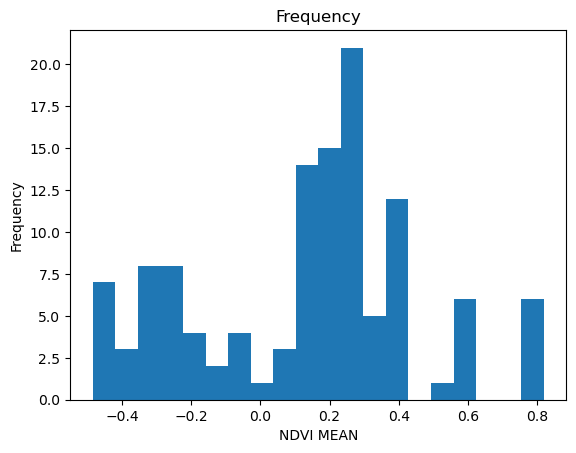

In [253]:
df_v3_get.ndvi_mean.plot(kind='hist',bins=20)
plt.xlabel('NDVI MEAN')
plt.title('Frequency')
plt.show()

In [254]:
df_v3_get.ndvi_std.plot(kind='hist',bins=20)
plt.xlabel('NDVI STD')
plt.title('Frequency')
plt.show()

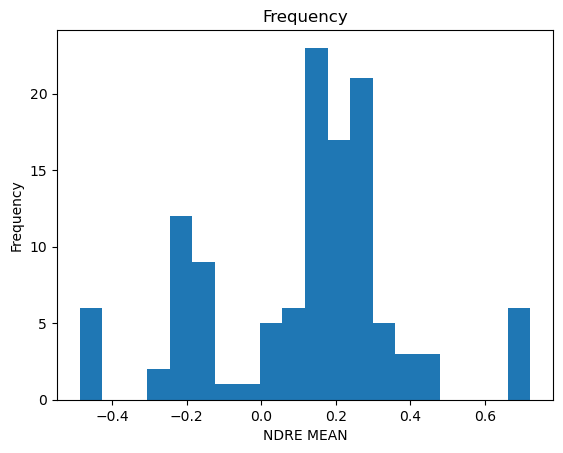

In [255]:
df_v3_get.ndre_mean.plot(kind='hist',bins=20)
plt.xlabel('NDRE MEAN')
plt.title('Frequency')
plt.show()

In [256]:
df_v3_get.ndre_std.plot(kind='hist',bins=20)
plt.xlabel('NDRE STD')
plt.title('Frequency')
plt.show()

In [257]:
scaler = MinMaxScaler()

df_v3_get['norm_ndvi_mean'] = scaler.fit_transform(df_v3_get[['ndvi_mean']])
df_v3_get['norm_ndvi_std'] = scaler.fit_transform(df_v3_get[['ndvi_std']].values)
df_v3_get['norm_ndre_mean'] = scaler.fit_transform(df_v3_get[['ndre_mean']].values)
df_v3_get['norm_ndre_std'] = scaler.fit_transform(df_v3_get[['ndre_std']].values)

#### treatment

In [258]:
treat_encoder = OneHotEncoder(handle_unknown='ignore')
treat_onehot=treat_encoder.fit_transform(df_all[['treatment']])
treatments=pd.DataFrame(treat_onehot.toarray())

In [259]:
all_treatments=treat_encoder.categories_[0]
for i in range(len(all_treatments)):
    df_v3_get[str(all_treatments[i])]=treatments.iloc[:,i]

In [261]:
trials=df_v3_get['trial_id'].tolist()
yields=df_v3_get['yield'].tolist()

Identifys=[]

for i in range(len(trials)):
    trail_id=trials[i]
    yie=float(yields[i])
    
    select=df_v3_get[(df_v3_get['trial_id'] == trail_id) & (df_v3_get['treatment']==1)]
    
#     print(trail_id)
    reference = select['yield'].values[0]
    
    check = 1 if abs(yie-reference) > reference*0.03 else 0
    Identifys.append(check)

In [262]:
df_v3_get['Identify'] = Identifys

#### Get more features - compare with treatment 1 condition

In [263]:
df_v3_get['ndvi_mean__diff'] = df_v3_get.groupby('trial_id')['norm_ndvi_mean'].transform(lambda x: x - x.iloc[0])
df_v3_get['ndvi_std_diff'] = df_v3_get.groupby('trial_id')['norm_ndvi_std'].transform(lambda x: x - x.iloc[0])
df_v3_get['ndre_mean_diff'] = df_v3_get.groupby('trial_id')['norm_ndre_mean'].transform(lambda x: x - x.iloc[0])
df_v3_get['ndre_std_diff'] = df_v3_get.groupby('trial_id')['norm_ndre_std'].transform(lambda x: x - x.iloc[0])

In [264]:
df_v3_get['mean_amp']=(df_v3_get['mean_vh']+df_v3_get['mean_vv'])/2
df_v3_get['std_amp']=(df_v3_get['std_vh']+df_v3_get['std_vv'])/2

df_v3_get['mean_vh_diff'] = df_v3_get.groupby('trial_id')['mean_vh'].transform(lambda x: x - x.iloc[0])
df_v3_get['median_vh_diff'] = df_v3_get.groupby('trial_id')['median_vh'].transform(lambda x: x - x.iloc[0])
df_v3_get['std_vh_diff'] = df_v3_get.groupby('trial_id')['std_vh'].transform(lambda x: x - x.iloc[0])
df_v3_get['mean_vv_diff'] = df_v3_get.groupby('trial_id')['mean_vv'].transform(lambda x: x - x.iloc[0])
df_v3_get['median_vv_diff'] = df_v3_get.groupby('trial_id')['median_vv'].transform(lambda x: x - x.iloc[0])
df_v3_get['std_vv_diff'] = df_v3_get.groupby('trial_id')['std_vv'].transform(lambda x: x - x.iloc[0])

In [265]:
### save all data in case
df_v3_get.to_csv('df_v3_get_incase.csv',index=None)

In [266]:
df_v3_get.shape

(120, 41)

*******************************************************************************************************

In [267]:
### get the columns fro modeling
df_model=df_v3_get[['trial_id','latitude', 'longitude',
       'norm_ndvi_mean', 'norm_ndvi_std', 'norm_ndre_mean', 'norm_ndre_std',
       'ndvi_mean__diff','ndvi_std_diff', 'ndre_mean_diff', 'ndre_std_diff',
       'mean_vh', 'median_vh', 'std_vh', 'mean_vv', 'median_vv', 'std_vv', 
       'mean_amp','std_amp', 'mean_vh_diff', 'median_vh_diff', 'std_vh_diff','mean_vv_diff', 'median_vv_diff', 'std_vv_diff',
        'closest_station_rain','closest_station_elevation',
        '1', '2', '3', '4', '5', '6','Identify']]

In [268]:
print("Successfull application",df_model[df_model.Identify==0].Identify.count())
print("Failure",df_model[df_model.Identify==1].Identify.count())
sns.countplot(data=df_model, x='Identify')

Successfull application 74
Failure 46


<AxesSubplot:xlabel='Identify', ylabel='count'>

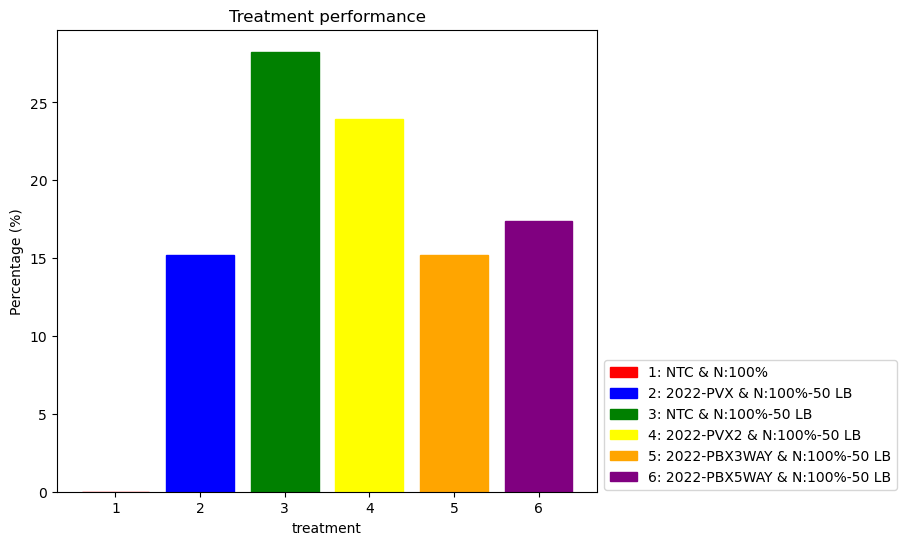

In [269]:
count_df = df_v3_get.groupby(['treatment'])['Identify'].sum().reset_index()
count_df['Percentage'] = (count_df['Identify'] / count_df['Identify'].sum()) * 100

type_meanings = {'1': 'NTC & N:100%', '2': '2022-PVX & N:100%-50 LB', '3': 'NTC & N:100%-50 LB', '4': '2022-PVX2 & N:100%-50 LB', '5': '2022-PBX3WAY & N:100%-50 LB', '6': '2022-PBX5WAY & N:100%-50 LB'}
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple']


plt.figure(figsize=(8, 6))
bars = plt.bar(count_df['treatment'], count_df['Percentage'])

for i, bar in enumerate(bars):
    bar.set_color(colors[i])
    
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
legend_labels = [f"{type_}: {meaning}" for type_, meaning in type_meanings.items()]
plt.legend(legend_handles, legend_labels,loc='upper left', bbox_to_anchor=(1, 0.3))

plt.xlabel('treatment')
plt.ylabel('Percentage (%)')
plt.title('Treatment performance')
plt.subplots_adjust(right=0.8)
plt.show()

# Modelling

In [293]:
model_names=[]
###for training
accuracys1=[]
precisions1=[]
recalls1=[]
f1s1=[]
roc_aucs1=[]
pr_aucs1=[]
###for testing
accuracys2=[]
precisions2=[]
recalls2=[]
f1s2=[]
roc_aucs2=[]
pr_aucs2=[]

In [287]:
df_model=df_model.dropna()
train_raw, test_raw = train_test_split(df_model,test_size=0.3, random_state=0)

In [289]:
train_raw.columns

Index(['trial_id', 'latitude', 'longitude', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff', 'mean_vh', 'median_vh', 'std_vh',
       'mean_vv', 'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_elevation', '1',
       '2', '3', '4', '5', '6', 'Identify'],
      dtype='object')

In [290]:
features = ['latitude', 'longitude', 'norm_ndvi_mean', 'norm_ndvi_std',
       'norm_ndre_mean', 'norm_ndre_std', 'ndvi_mean__diff', 'ndvi_std_diff',
       'ndre_mean_diff', 'ndre_std_diff', 'mean_vh', 'median_vh', 'std_vh',
       'mean_vv', 'median_vv', 'std_vv', 'mean_amp', 'std_amp', 'mean_vh_diff',
       'median_vh_diff', 'std_vh_diff', 'mean_vv_diff', 'median_vv_diff',
       'std_vv_diff', 'closest_station_rain', 'closest_station_elevation', '1',
       '2', '3', '4', '5', '6', 'Identify']

target = 'Identify'
features.remove(target)

X_train = train_raw[features]
y_train = train_raw[target]

X_test = test_raw[features]
y_test = test_raw[target]

In [291]:
def add_print_metrics1(model_idx, y, y_pred, y_proba):
    accuracys1.append(accuracy_score(y, y_pred))
    precisions1.append(precision_score(y, y_pred))
    recalls1.append(recall_score(y, y_pred))
    f1s1.append(f1_score(y, y_pred))
    roc_aucs1.append(metrics.roc_auc_score(y, y_proba[:,1]))
    pr_aucs1.append(average_precision_score(y,y_proba[:,1]))
    print(f"{model_names[model_idx]} Accuracy score is {accuracy_score(y, y_pred)}")
    print(f"{model_names[model_idx]} Precision score is {precision_score(y, y_pred)}")
    print(f"{model_names[model_idx]} Recall score is {recall_score(y, y_pred)}")
    print(f"{model_names[model_idx]} F1 score is {f1_score(y, y_pred)}")
    
    print(f"{model_names[model_idx]} ROC-AUC score is {metrics.roc_auc_score(y, y_proba[:,1])}")
    print(f"{model_names[model_idx]} PR-AUC score is {average_precision_score(y,y_proba[:,1])}")
    
def add_print_metrics2(model_idx, y, y_pred, y_proba):
    accuracys2.append(accuracy_score(y, y_pred))
    precisions2.append(precision_score(y, y_pred))
    recalls2.append(recall_score(y, y_pred))
    f1s2.append(f1_score(y, y_pred))
    roc_aucs2.append(metrics.roc_auc_score(y, y_proba[:,1]))
    pr_aucs2.append(average_precision_score(y,y_proba[:,1]))
    print(f"{model_names[model_idx]} Accuracy score is {accuracy_score(y, y_pred)}")
    print(f"{model_names[model_idx]} Precision score is {precision_score(y, y_pred)}")
    print(f"{model_names[model_idx]} Recall score is {recall_score(y, y_pred)}")
    print(f"{model_names[model_idx]} F1 score is {f1_score(y, y_pred)}")
    
    print(f"{model_names[model_idx]} ROC-AUC score is {metrics.roc_auc_score(y, y_proba[:,1])}")
    print(f"{model_names[model_idx]} PR-AUC score is {average_precision_score(y,y_proba[:,1])}")

In [292]:
# as this is an imbalanced dataset, we use PR-AUC as the evaluation metris in training
scorer = make_scorer(average_precision_score, greater_is_better = True)

<font size = '4'> <font color= 'blue'>
    Model----LogisticRegression
<font>

In [294]:
model_names.append('LR')

In [295]:
#### with amp
steps = [('rescale', StandardScaler()),      
         ('lr', LogisticRegression(class_weight = 'balanced',solver='liblinear'))]
model = Pipeline(steps)

params = {'lr__penalty':['l1','l2'],
           'lr__C': [0.1, 1, 10, 100]
           }

model_tun = GridSearchCV(estimator = model, param_grid = params, scoring = scorer, cv = 5,error_score="raise")

model_tun = model_tun.fit(X_train, y_train)

print('The best parameters finally chose are',model_tun.best_params_)
print('The ROC_AUC score from these parameters is',model_tun.best_score_)

y_train_pred_lr=model_tun.best_estimator_.predict(X_train)
y_train_proba_lr = model_tun.best_estimator_.predict_proba(X_train)

y_test_pred_lr=model_tun.best_estimator_.predict(X_test)
y_test_proba_lr = model_tun.best_estimator_.predict_proba(X_test)


print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(0,y_train,y_train_pred_lr,y_train_proba_lr)
print("-------------------------Test dataset Result------------------------------")
add_print_metrics2(0,y_test,y_test_pred_lr,y_test_proba_lr)

The best parameters finally chose are {'lr__C': 0.1, 'lr__penalty': 'l2'}
The ROC_AUC score from these parameters is 0.4350937950937951
-------------------------Train dataset Result------------------------------
LR Accuracy score is 0.7586206896551724
LR Precision score is 0.5714285714285714
LR Recall score is 0.8888888888888888
LR F1 score is 0.6956521739130435
LR ROC-AUC score is 0.8833333333333333
LR PR-AUC score is 0.8027105675497489
-------------------------Test dataset Result------------------------------
LR Accuracy score is 0.64
LR Precision score is 0.4666666666666667
LR Recall score is 0.875
LR F1 score is 0.608695652173913
LR ROC-AUC score is 0.7867647058823529
LR PR-AUC score is 0.6514880952380953


In [297]:
coefficients = model_tun.best_estimator_.named_steps['lr'].coef_[0]

feature_importance = np.abs(coefficients)
# feature_importance = coefficients
feature_names = X_train.columns.values

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plotting the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), sorted_importance, color='steelblue')

# Add vertical grid lines
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Customize tick labels font size
plt.xticks(fontsize=12)
plt.yticks(range(len(sorted_importance)), sorted_feature_names, fontsize=12)

# Add a title and axis labels
plt.title('Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Add a horizontal line at y=0
plt.axvline(x=0, color='gray', linewidth=0.5)

# Add a legend with a description
plt.legend(['Zero Importance'], loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [298]:
compare=pd.DataFrame(y_test)
compare.columns=['Real']
compare['Predict']=y_test_pred_lr

In [299]:
cm = confusion_matrix(y_test, y_test_pred_lr)

class_labels = ['Success', 'Failure']
                
print("Confusion Matrix:")
print(cm)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.subplot()

# Create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

# for i in range(len(class_labels)):
#     for j in range(len(class_labels)):
#         ax.text(j + 0.5, i + 0.5, cm[i, j], ha='center', va='center', color='black')

# for i in range(len(class_labels)):
#     TP = cm[i, i]
#     FP = np.sum(cm[:, i]) - TP
#     TN = np.sum(cm) - np.sum(cm[:, i]) - np.sum(cm[i, :]) + TP
#     FN = np.sum(cm[i, :]) - TP

#     ax.text(len(class_labels) + 0.5, i + 0.5, f'TP: {TP}', ha='left', va='center', color='green')
#     ax.text(len(class_labels) + 1.5, i + 0.5, f'FP: {FP}', ha='left', va='center', color='red')
#     ax.text(len(class_labels) + 3.0, i + 0.5, f'TN: {TN}', ha='left', va='center', color='green')
#     ax.text(len(class_labels) + 4.5, i + 0.5, f'FN: {FN}', ha='left', va='center', color='red')
    
# Set labels, title, and ticks
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels, rotation=45, ha='right')
ax.yaxis.set_ticklabels(class_labels, rotation=0)

plt.show()

Confusion Matrix:
[[9 8]
 [1 7]]


In [402]:
steps1 = [('rescale', StandardScaler()),      
         ('lr', LogisticRegression(class_weight = 'balanced',solver='liblinear'))]
model1 = Pipeline(steps1)

params1 = {'lr__penalty':['l1','l2'],
           'lr__C': [0.1, 1, 10, 100]
           }

model1_tun = GridSearchCV(estimator = model1, param_grid = params1, scoring = scorer, cv = 5,error_score="raise")

model1_tun = model1_tun.fit(X_train, y_train)

print('The best parameters finally chose are',model1_tun.best_params_)
print('The ROC_AUC score from these parameters is',model1_tun.best_score_)

y_train_pred_lr=model1_tun.best_estimator_.predict(X_train)
y_train_proba_lr = model1_tun.best_estimator_.predict_proba(X_train)

y_test_pred_lr=model1_tun.best_estimator_.predict(X_test)
y_test_proba_lr = model1_tun.best_estimator_.predict_proba(X_test)


print("-------------------------Train dataset Result------------------------------")
add_print_metrics1(0,y_train,y_train_pred_lr,y_train_proba_lr)
print("-------------------------Test dataset Result------------------------------")
add_print_metrics2(0,y_test,y_test_pred_lr,y_test_proba_lr)

The best parameters finally chose are {'lr__C': 10, 'lr__penalty': 'l1'}
The ROC_AUC score from these parameters is 0.4462781954887218
-------------------------Train dataset Result------------------------------
LR Accuracy score is 0.5625
LR Precision score is 0.4634146341463415
LR Recall score is 0.48717948717948717
LR F1 score is 0.47500000000000003
LR ROC-AUC score is 0.6477732793522267
LR PR-AUC score is 0.5834353512493368
-------------------------Test dataset Result------------------------------
LR Accuracy score is 0.3333333333333333
LR Precision score is 0.23529411764705882
LR Recall score is 0.5714285714285714
LR F1 score is 0.3333333333333333
LR ROC-AUC score is 0.4369747899159664
LR PR-AUC score is 0.396485260770975


In [300]:
# plot ROC curve and PR curve

fpr, tpr, th = roc_curve(y_train, y_train_proba_lr[:, 1])
fpr1, tpr1, th1 = roc_curve(y_test, y_test_proba_lr[:, 1])

precision, recall, threshold = precision_recall_curve(y_train, y_train_proba_lr [:,1])
precision1, recall1, threshold1 = precision_recall_curve(y_test, y_test_proba_lr [:,1])

fig, axe = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(10)

axe[0, 0].plot(fpr, tpr)
axe[0, 0].set_xlabel('fpr')
axe[0, 0].set_ylabel('tpr')
axe[0, 0].set_title('train ROC curve')

axe[0, 1].plot(fpr1, tpr1)
axe[0, 1].set_xlabel('fpr')
axe[0, 1].set_ylabel('tpr')
axe[0, 1].set_title('test ROC curve')

axe[1, 0].plot(recall, precision)
axe[1, 0].set_xlabel('recall')
axe[1, 0].set_ylabel('precision')
axe[1, 0].set_title('train PR curve')
axe[1, 0].set_ylim(0, 1)


axe[1, 1].plot(recall1, precision1)
axe[1, 1].set_xlabel('recall')
axe[1, 1].set_ylabel('precision')
axe[1, 1].set_title('test PR curve')
axe[1, 1].set_ylim(0, 1)


plt.show()

In [277]:
df_all.stage.unique()

array(['V0', 'VE', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V10', 'V11',
       'V12', 'VT', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R6+', 'V9', 'V8'],
      dtype=object)

###  Stage V4

###  Stage V6